## Description

This takes as input the root file containing the reco hits from DD4HEP and the output of the converter that produces the H5 file.  It makes some comparison histograms.  Ideally, the histograms will be identical.  Since the converter makes a few cuts on the hits, the cuts need to be applied here to the root data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors


from IPython.display import display_html 


from numpy import inf
import os

from os import listdir

import awkward as ak

import uproot3 #will not work with uproot4

import h5py as h5

### Set the input files here

In [2]:
input_root_file = '2M_piplus.root'

#input_hdf5_file = '../../regressiononly/2M_uncompressed.hdf5'
#input_hdf5_file = "nosplit.hdf5"
input_hdf5_file = "simple_GeV.hdf5"
input_hdf5_file = "Ecut_GeV.hdf5"
#input_hdf5_file = "GeV_cluster_noskip.hdf5"

nevents = 1000


hit_e_max = 1e10
hit_e_min = 0.06/1000
hit_t_max = 200


In [3]:
ur_file = uproot3.open( input_root_file )

print( ur_file.keys() )

ur_tree = ur_file['events']

print( ur_tree )

ur_tree.show()

[b'events;1', b'metadata;1', b'run_metadata;1', b'evt_metadata;1', b'col_metadata;1']
<TTree b'events' at 0x7ff9deadd7c0>
HcalBarrelHitsDigi         TStreamerSTL               asdtype('>i4')
HcalBarrelHitsDigi.cellID  TStreamerBasicType         asjagged(asdtype('>u8'))
HcalBarrelHitsDigi.amplitude
                           TStreamerBasicType         asjagged(asdtype('>u8'))
HcalBarrelHitsDigi.timeStamp
                           TStreamerBasicType         asjagged(asdtype('>u8'))

HcalBarrelHitsReco         TStreamerSTL               asdtype('>i4')
HcalBarrelHitsReco.cellID  TStreamerBasicType         asjagged(asdtype('>u8'))
HcalBarrelHitsReco.energy  TStreamerBasicType         asjagged(asdtype('>f4'))
HcalBarrelHitsReco.energyError
                           TStreamerBasicType         asjagged(asdtype('>f4'))
HcalBarrelHitsReco.time    TStreamerBasicType         asjagged(asdtype('>f4'))
HcalBarrelHitsReco.timeError
                           TStreamerBasicType         asjagged(asdty

In [4]:
h5_file = h5.File(input_hdf5_file,'r')

print(list(h5_file.keys()))

['hcal', 'mc']


In [5]:
short_to_branch_dict = {}
short_to_branch_dict['hcal'] = 'HcalEndcapPHitsReco'
short_to_branch_dict['hcali'] = 'HcalEndcapPInsertHitsReco'
short_to_branch_dict

{'hcal': 'HcalEndcapPHitsReco', 'hcali': 'HcalEndcapPInsertHitsReco'}

### Make a choice on which detector subsystem you want to look at.

In [6]:
#group_to_check = 'hcali'
group_to_check = 'hcal'

In [7]:
#h5_group_to_check = 'test_hcali'
h5_group_to_check = 'hcal'

In [8]:
root_hits_x = ur_tree.array('%s.position.x' % short_to_branch_dict[group_to_check] , entrystop=nevents)
root_hits_y = ur_tree.array('%s.position.y' % short_to_branch_dict[group_to_check], entrystop=nevents)
root_hits_z = ur_tree.array('%s.position.z' % short_to_branch_dict[group_to_check], entrystop=nevents)
root_hits_t = ur_tree.array('%s.time' % short_to_branch_dict[group_to_check], entrystop=nevents)
root_hits_e = ur_tree.array('%s.energy' % short_to_branch_dict[group_to_check], entrystop=nevents)
#root_hits_e = root_hits_e*1000


genPx = ur_tree.array('MCParticles.momentum.x',entrystop=nevents*10)[:,2]
genPy = ur_tree.array('MCParticles.momentum.y',entrystop=nevents*10)[:,2]
genPz = ur_tree.array('MCParticles.momentum.z',entrystop=nevents*10)[:,2]
root_genP = np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)

In [9]:
h5_group = h5_file[h5_group_to_check]
h5_mc_group = h5_file['mc']

In [10]:
h5_hits_e = h5_group[:nevents,0] #already GeV->MeV
h5_hits_x = h5_group[:nevents,1]
h5_hits_y = h5_group[:nevents,2]
h5_hits_z = h5_group[:nevents,3]

h5_hits_e = np.nan_to_num( h5_hits_e )
h5_hits_x = np.nan_to_num( h5_hits_x )
h5_hits_y = np.nan_to_num( h5_hits_y )
h5_hits_z = np.nan_to_num( h5_hits_z )


h5_genP = h5_mc_group[:nevents*10,8]

In [11]:
def make_comparison_plots( root_array, h5_array, var_name, yscale='log' ) :
    
    fig,ax = plt.subplots( 1, 2, figsize=(20, 9) )
    
    gen_string = "gen"
    if gen_string.lower() not in var_name.lower():
        root_cuts = root_hits_e > hit_e_min
        root_cuts = np.logical_and( root_cuts, root_hits_e <= hit_e_max )
        root_cuts = np.logical_and( root_cuts, root_hits_t <= hit_t_max )
    
        root_hist = ax[0].hist( root_array[root_cuts].flatten(), bins=200 )
        h5_hist   = ax[1].hist( h5_array[h5_hits_e>0].flatten(), bins=200 )
    
    else:
        root_hist = ax[0].hist( root_array.flatten(), bins=200 )
        h5_hist   = ax[1].hist( h5_array.flatten(), bins=200 )
    
    ax[0].set_yscale( yscale )
    ax[1].set_yscale( yscale )
    
    ax[0].set_title('Root', fontsize=21 )
    ax[1].set_title('H5', fontsize=21)
    
    ax[0].set_xlabel( var_name )
    ax[1].set_xlabel( var_name )
        
    plt.show()

    print("  array length:  %d" % len(root_hist[0]) )

    n_diffs = 0
    for bi in range( len(root_hist[0]) ):
        if root_hist[0][bi] == 0 and h5_hist[0][bi] == 0 : continue
        print( '%4d  :  %9.0f  %9.0f  %s' % (bi, root_hist[0][bi], h5_hist[0][bi],  root_hist[2][bi]), end='' )
        if root_hist[0][bi] != h5_hist[0][bi] :
            print(" *** %.0f" % (root_hist[0][bi] - h5_hist[0][bi]))
            n_diffs = n_diffs + 1
        else:
            print()

    print("\n\n Number of differences:  %d\n\n" % n_diffs )
    

/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/awkward0/array/base.py:622: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(where, (cls.numpy.ndarray, AwkwardArray)) and issubclass(where.dtype.type, (numpy.str, numpy.str_)):
/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/awkward0/array/base.py:624: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

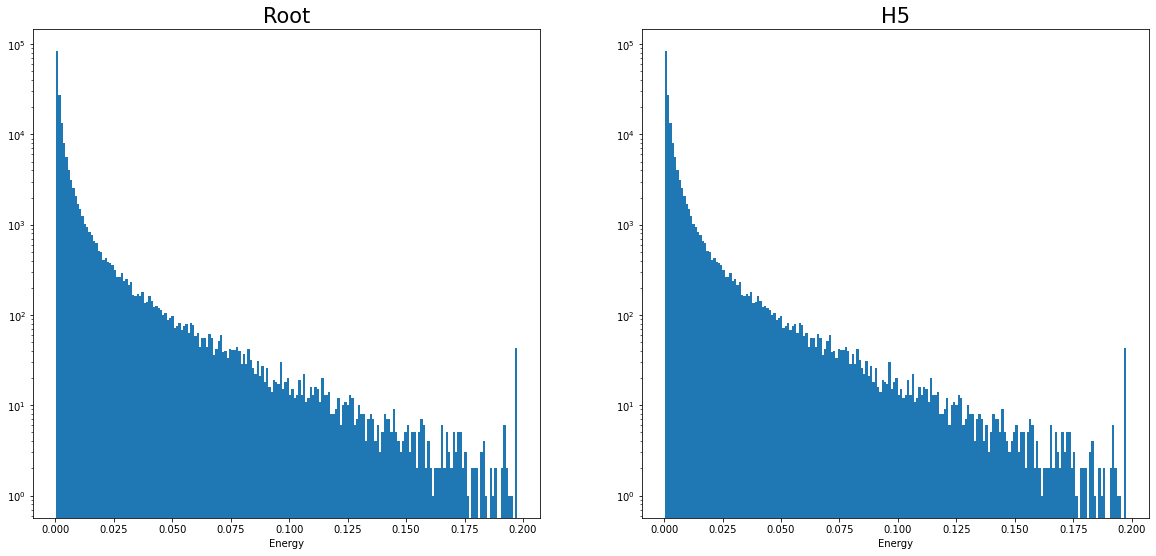

  array length:  200
   0  :      84512      84512  Rectangle(xy=(0.000305176, 0), width=0.000986267, height=84512, angle=0)
   1  :      27025      27025  Rectangle(xy=(0.00129144, 0), width=0.000986267, height=27025, angle=0)
   2  :      13251      13251  Rectangle(xy=(0.00227771, 0), width=0.000986267, height=13251, angle=0)
   3  :       8002       8002  Rectangle(xy=(0.00326398, 0), width=0.000986267, height=8002, angle=0)
   4  :       5590       5590  Rectangle(xy=(0.00425024, 0), width=0.000986267, height=5590, angle=0)
   5  :       4045       4045  Rectangle(xy=(0.00523651, 0), width=0.000986267, height=4045, angle=0)
   6  :       3162       3162  Rectangle(xy=(0.00622278, 0), width=0.000986267, height=3162, angle=0)
   7  :       2537       2537  Rectangle(xy=(0.00720905, 0), width=0.000986267, height=2537, angle=0)
   8  :       2064       2064  Rectangle(xy=(0.00819531, 0), width=0.000986267, height=2064, angle=0)
   9  :       1697       1697  Rectangle(xy=(0.00918158, 

In [12]:
make_comparison_plots( root_hits_e, h5_hits_e, 'Energy' )

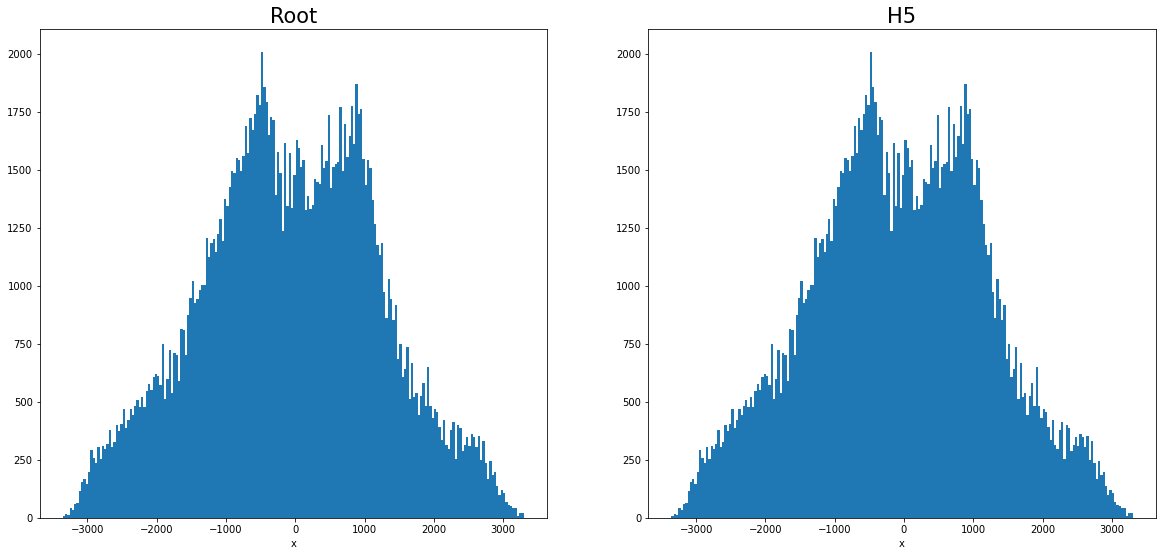

  array length:  200
   0  :          8          8  Rectangle(xy=(-3356.72, 0), width=33.2737, height=8, angle=0)
   1  :         15         15  Rectangle(xy=(-3323.44, 0), width=33.2737, height=15, angle=0)
   2  :         13         13  Rectangle(xy=(-3290.17, 0), width=33.2737, height=13, angle=0)
   3  :         42         42  Rectangle(xy=(-3256.9, 0), width=33.2737, height=42, angle=0)
   4  :         33         33  Rectangle(xy=(-3223.62, 0), width=33.2737, height=33, angle=0)
   5  :         61         61  Rectangle(xy=(-3190.35, 0), width=33.2737, height=61, angle=0)
   6  :         63         63  Rectangle(xy=(-3157.07, 0), width=33.2737, height=63, angle=0)
   7  :        114        114  Rectangle(xy=(-3123.8, 0), width=33.2737, height=114, angle=0)
   8  :        156        156  Rectangle(xy=(-3090.53, 0), width=33.2737, height=156, angle=0)
   9  :        169        169  Rectangle(xy=(-3057.25, 0), width=33.2737, height=169, angle=0)
  10  :        147        147  Rectangl

In [13]:
make_comparison_plots( root_hits_x, h5_hits_x, 'x', 'linear' )

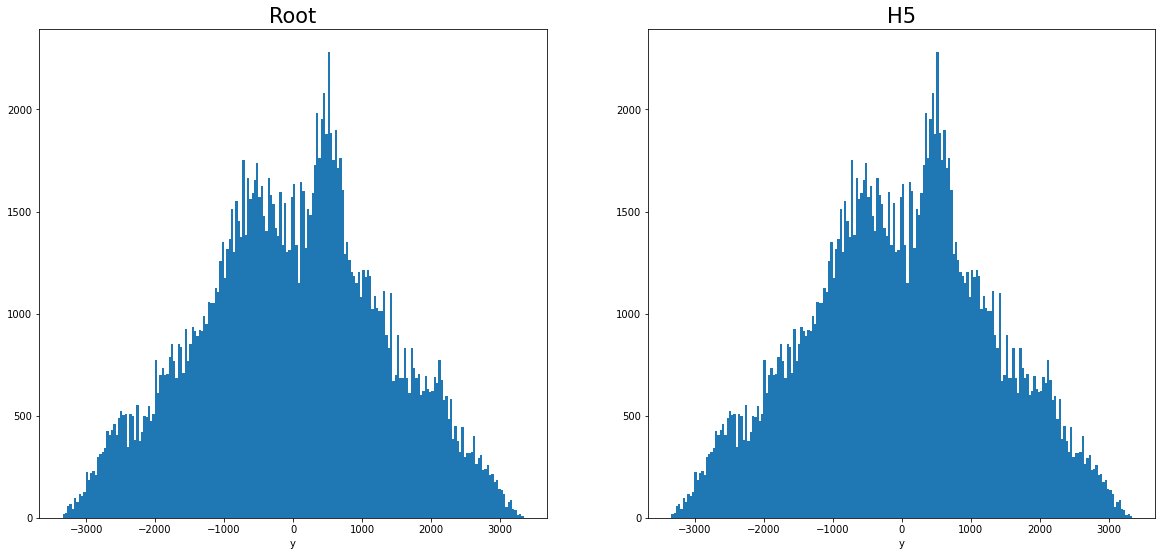

  array length:  200
   0  :         17         17  Rectangle(xy=(-3342.85, 0), width=33.4285, height=17, angle=0)
   1  :         23         23  Rectangle(xy=(-3309.42, 0), width=33.4285, height=23, angle=0)
   2  :         56         56  Rectangle(xy=(-3275.99, 0), width=33.4285, height=56, angle=0)
   3  :         67         67  Rectangle(xy=(-3242.56, 0), width=33.4285, height=67, angle=0)
   4  :         41         41  Rectangle(xy=(-3209.13, 0), width=33.4285, height=41, angle=0)
   5  :         98         98  Rectangle(xy=(-3175.7, 0), width=33.4285, height=98, angle=0)
   6  :         78         78  Rectangle(xy=(-3142.28, 0), width=33.4285, height=78, angle=0)
   7  :        118        118  Rectangle(xy=(-3108.85, 0), width=33.4285, height=118, angle=0)
   8  :        106        106  Rectangle(xy=(-3075.42, 0), width=33.4285, height=106, angle=0)
   9  :        127        127  Rectangle(xy=(-3041.99, 0), width=33.4285, height=127, angle=0)
  10  :        223        223  Rectan

In [14]:
make_comparison_plots( root_hits_y, h5_hits_y, 'y', 'linear' )

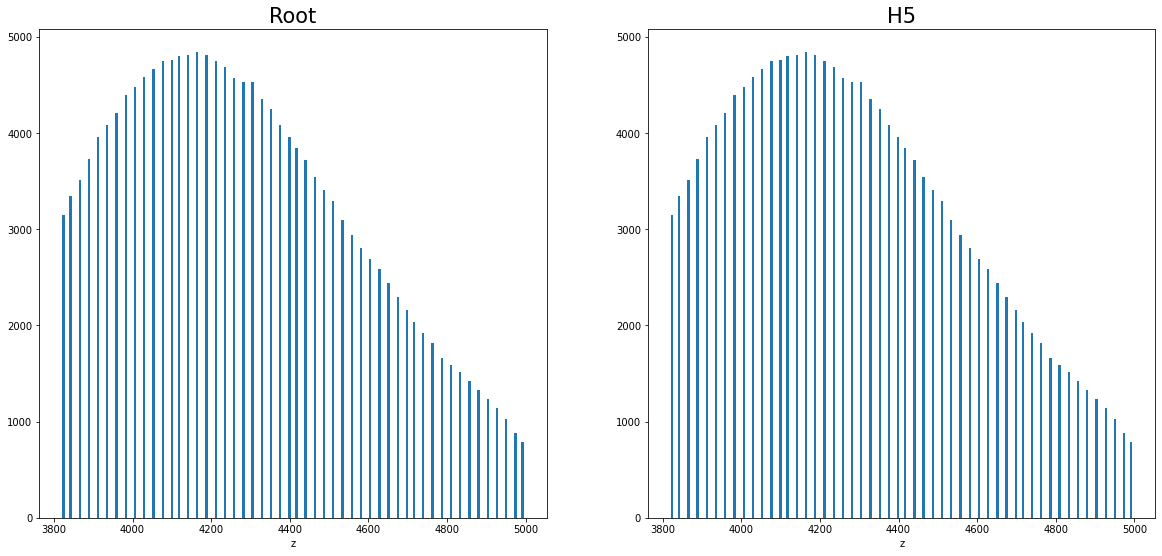

  array length:  200
   0  :       3148       3148  Rectangle(xy=(3821.5, 0), width=5.86499, height=3148, angle=0)
   3  :       3343       3343  Rectangle(xy=(3839.09, 0), width=5.86499, height=3343, angle=0)
   7  :       3507       3507  Rectangle(xy=(3862.55, 0), width=5.86499, height=3507, angle=0)
  11  :       3730       3730  Rectangle(xy=(3886.01, 0), width=5.86499, height=3730, angle=0)
  15  :       3962       3962  Rectangle(xy=(3909.48, 0), width=5.86499, height=3962, angle=0)
  19  :       4083       4083  Rectangle(xy=(3932.94, 0), width=5.86499, height=4083, angle=0)
  23  :       4211       4211  Rectangle(xy=(3956.4, 0), width=5.86499, height=4211, angle=0)
  27  :       4396       4396  Rectangle(xy=(3979.85, 0), width=5.86499, height=4396, angle=0)
  31  :       4477       4477  Rectangle(xy=(4003.31, 0), width=5.86499, height=4477, angle=0)
  35  :       4582       4582  Rectangle(xy=(4026.77, 0), width=5.86499, height=4582, angle=0)
  39  :       4669       4669  

In [15]:
make_comparison_plots( root_hits_z, h5_hits_z, 'z', 'linear' )

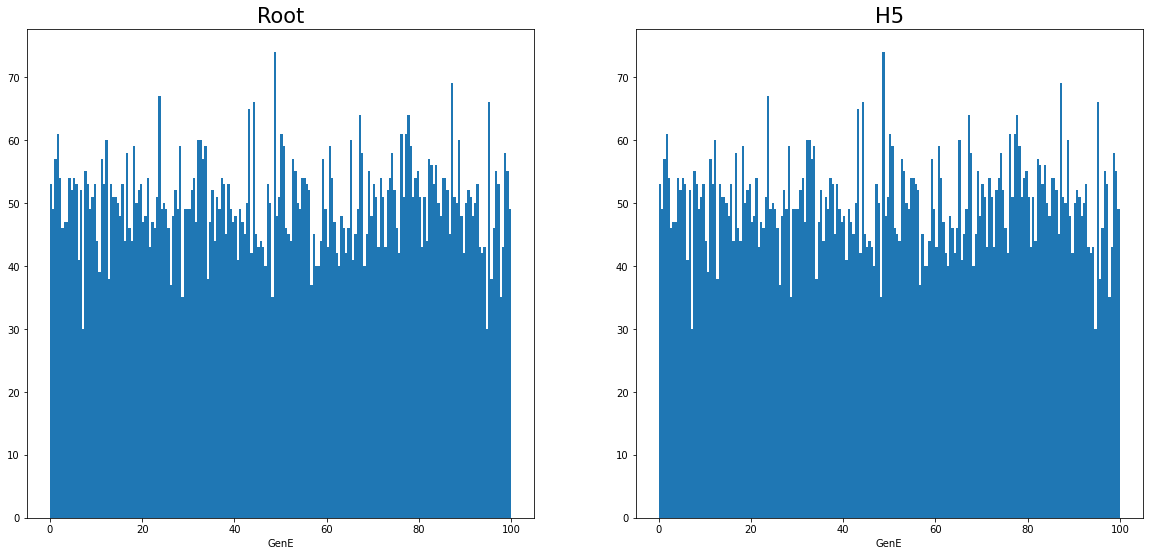

  array length:  200
   0  :         53         53  Rectangle(xy=(0.0030051, 0), width=0.4999, height=53, angle=0)
   1  :         49         49  Rectangle(xy=(0.502906, 0), width=0.4999, height=49, angle=0)
   2  :         57         57  Rectangle(xy=(1.00281, 0), width=0.4999, height=57, angle=0)
   3  :         61         61  Rectangle(xy=(1.50271, 0), width=0.499901, height=61, angle=0)
   4  :         54         54  Rectangle(xy=(2.00261, 0), width=0.4999, height=54, angle=0)
   5  :         46         46  Rectangle(xy=(2.50251, 0), width=0.499901, height=46, angle=0)
   6  :         47         47  Rectangle(xy=(3.00241, 0), width=0.4999, height=47, angle=0)
   7  :         47         47  Rectangle(xy=(3.50231, 0), width=0.4999, height=47, angle=0)
   8  :         54         54  Rectangle(xy=(4.00221, 0), width=0.499901, height=54, angle=0)
   9  :         52         52  Rectangle(xy=(4.50211, 0), width=0.4999, height=52, angle=0)
  10  :         54         54  Rectangle(xy=(5.002

In [16]:
make_comparison_plots(root_genP, h5_genP, 'GenE', 'linear' ) #root SCALE?